In [6]:
# --- 1. Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, roc_curve, ConfusionMatrixDisplay

In [7]:
# --- 2. Load Data ---
df =df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.drop("customerID", axis=1, inplace=True)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

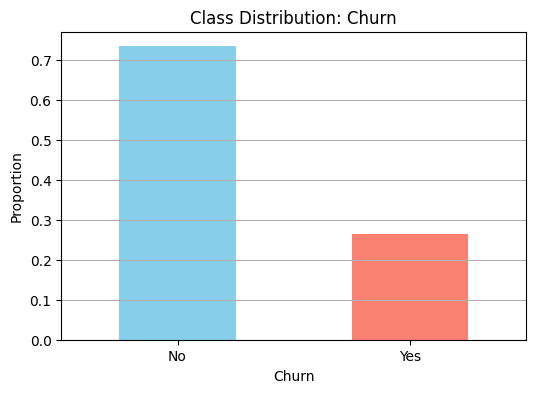

In [8]:
# --- 3. EDA ---
plt.figure(figsize=(6, 4))
df['Churn'].value_counts(normalize=True).plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution: Churn')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

In [9]:
# --- 4. Preprocessing ---
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
categorical_features.remove('Churn')
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

X = df.drop('Churn', axis=1)
y = df['Churn'].map({'No': 0, 'Yes': 1})

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
], remainder='passthrough')


In [10]:
# --- 5. Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


In [11]:
# --- 6. Models ---
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000),
    "Random Forest": RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
}


Logistic Regression - F1 Score: 0.628, ROC-AUC: 0.846
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.50      0.78      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409



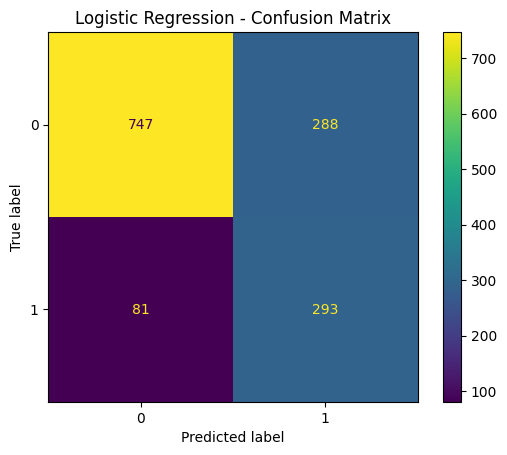


Random Forest - F1 Score: 0.536, ROC-AUC: 0.821
              precision    recall  f1-score   support

           0       0.82      0.89      0.86      1035
           1       0.62      0.48      0.54       374

    accuracy                           0.78      1409
   macro avg       0.72      0.68      0.70      1409
weighted avg       0.77      0.78      0.77      1409



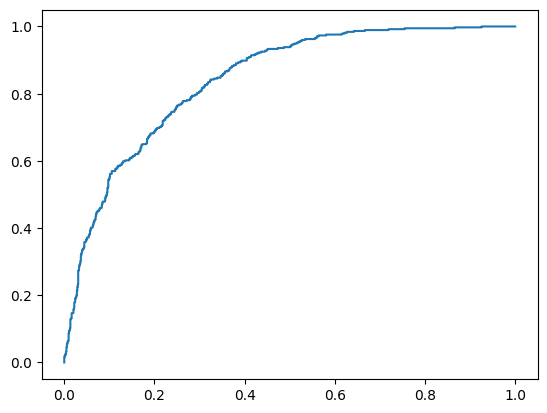

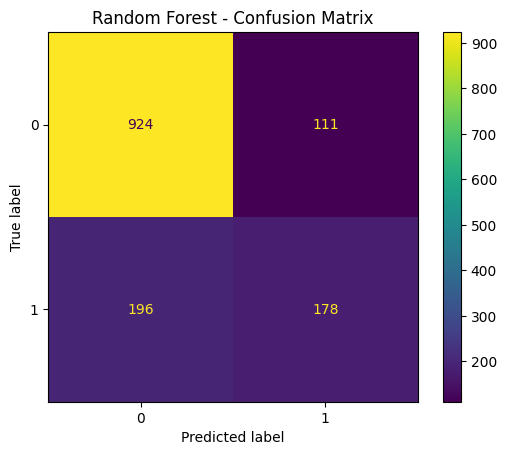

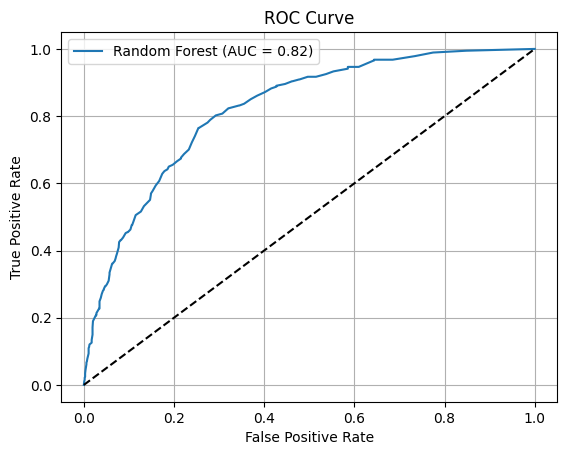

In [12]:
# --- 7. Evaluation ---
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    f1 = cross_val_score(pipe, X_train, y_train, cv=skf, scoring='f1').mean()
    roc_auc = cross_val_score(pipe, X_train, y_train, cv=skf, scoring='roc_auc').mean()
    print(f"\n{name} - F1 Score: {f1:.3f}, ROC-AUC: {roc_auc:.3f}")

    # Fit and predict
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    print(classification_report(y_test, y_pred))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(f'{name} - Confusion Matrix')
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, y_proba):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


📊 1. Class Imbalance Observation

Figure: Class Distribution - Churn

The bar plot reveals a class imbalance, with ~26% of customers classified as "Yes" (Churn) and ~74% as "No". This imbalance justifies the application of class weighting and the usage of evaluation metrics like F1-score and ROC-AUC, rather than accuracy alone, to avoid misleading model performance interpretations.

🤖 2. Model Evaluation & Comparison
🔸 Logistic Regression

F1 Score: 0.628

ROC-AUC: 0.846

Precision/Recall for class '1' (Churn):

Precision: 0.50

Recall: 0.78

Confusion Matrix:

False Negatives (81) and False Positives (288) indicate an aggressive positive prediction tendency.

Interpretation:
Logistic Regression, with class balancing, achieves high recall but relatively lower precision on the minority class. This indicates the model is conservative in missing churned customers (low FN) but triggers more false alarms (high FP).

🔸 Random Forest Classifier

F1 Score: 0.536

ROC-AUC: 0.821

Precision/Recall for class '1' (Churn):

Precision: 0.62

Recall: 0.48

Confusion Matrix:

196 False Negatives, 111 False Positives

Interpretation:
The Random Forest model demonstrates better precision but sacrifices recall, making it more selective but at the cost of overlooking actual churners. This behavior is common in ensemble models when decision thresholds are not explicitly adjusted.

📈 3. ROC Curve Analysis

Both models show ROC-AUC scores above 0.80, with Logistic Regression slightly outperforming Random Forest. This confirms that both classifiers are effective at distinguishing between churn and non-churn classes on a probability basis.

🎓 Conclusion & Recommendations

Model Trade-offs: Logistic Regression favors recall, making it suitable for retention-focused interventions where missing a potential churn is costly. Conversely, Random Forest is better for precision-oriented scenarios to avoid false alarms.

Business Implication: In customer churn scenarios, recall is usually prioritized—better to act on a potential churner (even if they wouldn’t churn) than to do nothing and lose a customer. Logistic Regression is the better candidate under this consideration.

Next Steps:

Calibrate decision thresholds

Apply SMOTE or under-sampling to further explore balance impact

Incorporate cost-sensitive learning

Deploy explainability tools like SHAP to interpret feature importance